# Automated Image Analysis of Bipolar Microelectrode Array Data



### Peter Defnet
*Up to date as of 022821*



### *Part 1: ImageJ Macro Language Script*

The ImageJ macro produces a thresholded image of the array. This will serve as the template for which values are mapped to in Python, and therefore it is critical that the product looks uniform and representative of the original array.

We start by setting up local variables to enable automatic saving, used later in the script. 'filename_load' is simply the name of the tiff stack as a string, and 'file_extension' is the path where the results will be saved. The specific path for the thresholded image (.tif) and results (.txt) are also defined.

In [1]:
#//Set Saving Parameters and Create Directories

#filename_load = "ECL-CV Example Data" // This name should match the title of the open video. 
#file_extension = "D:/ECL Data/ProgramOutput/" + filename_load + "/" // Names the folder to save data into. 

#File.makeDirectory(file_extension) //Creates folder to save data into. 
#Save_threshold = file_extension + "thresh_" + filename_load + ".tif" //Creates name of thresholded image file.
#Save_results = file_extension + "Results_" + filename_load + ".txt" // Creates name of results data file. 


The general strategy will be to average the pixel intensities across 200 non-light producing frames (typically found at the start of the video). This produces a sufficient-resolution image clearly showing the array’s structure. This image is then inverted to make the electrodes white with a dark background, converted to 8-bit, and then locally thresholded. Figure 1 displays this process.

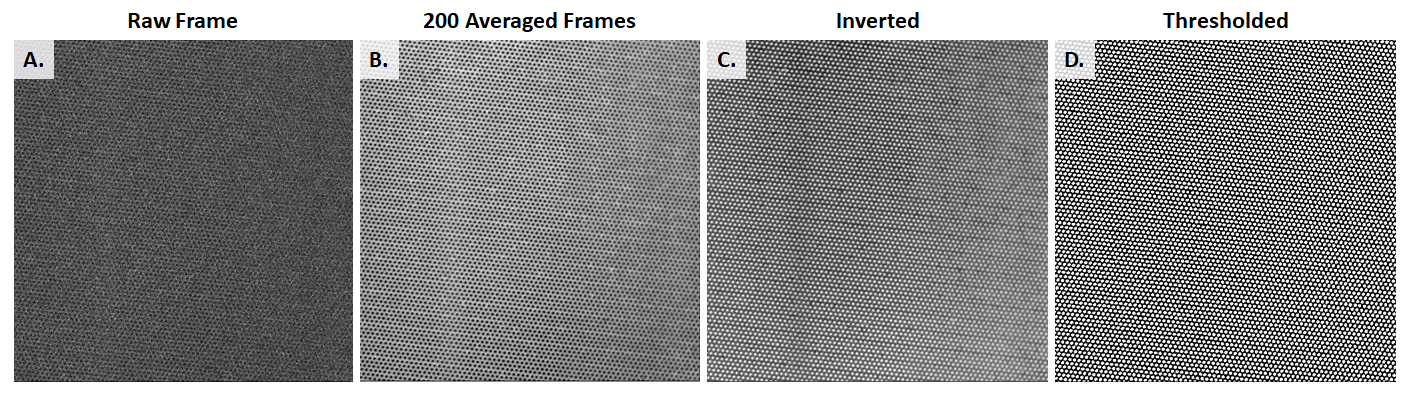

In [2]:
from IPython.display import Image
Image(filename='C:/Users/Peter/Desktop/Github/Spatially Mapping Electrode Response Data using Python & ImageJ/Figure 1.png') 

In [3]:
#// Define Thresholded image by averaging the first 200 blank frames.
#// (Averaging the noise in 200 blank frames uses the ambient light present during recording to reveal electrode locations)

#selectWindow(filename_load + ".tif"); // Select window of video.

#run("Duplicate...", "duplicate range=1-200"); // Duplicate frames 1-200
#run("Z Project...", "projection=[Average Intensity]"); // Find Average Intensity of these first 200 frames. 
#run("Invert"); // Invert the colors of Avg
#run("8-bit"); // Convert to 8-bit image
#run("Auto Local Threshold", "method=Median radius=5 parameter_1=0 parameter_2=0 white"); //Apply local threshold, such that the electrode locations and background are binarized.

The quality of the thresholded image is then improved by ensuring each electrode is separate from its neighbors (i.e., pixels are not connecting) with the “Watershed” method and fill any holes produced during thresholding with the “Fill Holes” method. The thresholded image is then saved and later used in Python.

In [4]:
#run("Options...", "iterations=1 count=1 black do=Nothing"); //white objects, black background
#run("Watershed"); //Separate the electrodes connected by corners
#run("Fill Holes"); // Fill holes in electrodes, making for a more well-rounded shape. 
#run("Watershed"); // Again, separate the electrodes connected by corners
#saveAs("Tiff", Save_threshold); //Save thresholded image. The thresholded image serves as a blank canvas to map values onto in         the .py program. 


The ROI’s are then identified from the thresholded image, applied to our (1500 frame) tiff stack, and the intensity-time data is extracted from each respective electrode position. The data is saved for later analysis in Python.

In [5]:
#//Obtain data from each ROI in thresholded image.

#run("Analyze Particles...", "size=5-Infinity display clear add"); // Identify regions with a size of >5 pixels. Anything small is considered noise. 
#run("Set Measurements...", "mean centroid area_fraction stack display redirect=None decimal=3"); // Set which values to     extract in results file. 
#roiManager("Associate", "false"); // Explicitly set parameters of ROI manager. 
#roiManager("Centered", "false"); // Explicitly set parameters of ROI manager. 
#roiManager("UseNames", "true"); // Explicitly set parameters of ROI manager. 
#selectWindow(filename_load + ".tif"); // Select video.
#roiManager("multi-measure measure_all"); // Extract selected values from each location identified in ROI manager. 
#saveAs("Results", Save_results); // Save results as a .txt file. The intensity data will be processed in Python to summarize            each electrode's individual response. 

### *Part 2:  Python Analysis:*

In Python, we import both the thresholded image, and results data from the folders from which they were saved in Imagej. Note that 'filename_load' and 'file_extension' are defined identically as they were in Imagej, and represent the only inputs for this program.

In [6]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from skimage import io, measure
import warnings
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 600 #Changes DPI of in-line figures.


"""Load and Clean Data""" 

#Load Directory. 
filename_load = 'ECL-CV Example Data' #number on thresh, results files. 
file_extension = 'D:/ECL Data/ProgramOutput/'
save_folder = file_extension + str(filename_load)

#Load Thresholded Image
img = io.imread(file_extension + str(filename_load) + '/' + 'thresh_' + str(filename_load) + '.tif')


#Import ROI results df #Saved results in imagej from ROI manager. 
res = pd.read_csv(file_extension + str(filename_load) + '/' + 'Results_' + str(filename_load) + '.txt', sep = '\t')
res.columns = ['Count', 'Label', 'Mean', 'X', 'Y', '%Area', 'Slice']

Some minor data cleaning is performed to create a subset containing only the ROI number and (x,y) coordinates for the imagej regions.

In [7]:
#Create ROI Column
res['ROI'] = res['Label'].apply(lambda x: (x.split(":",2)[1]).split("-",1)[0]) #Select ROI # from Label. #Splitting on ":" makes sure this should always work.
res['ROI'] = res['ROI'].astype(int) #Convert ROI to integer


#df to extract Intensity-Frame profiles from. 
res_sort = res.sort_values(["ROI", "Slice"], ascending = (True, True)) #Sort by ROI, Slice#. 
res_sort.reset_index(drop=True, inplace=True)


#subset df to pull unique ROI #'s and xy coords
coords = res.drop_duplicates(['ROI'])

df = coords[['ROI', 'X', 'Y']] 
df.loc[:,'X'] = np.round(df.loc[:,'X'], decimals=0)
df.loc[:,'Y'] = np.round(df.loc[:,'Y'], decimals=0)

C:\Users\Peter\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Next, the thresholded image, “img” is ‘labeled’ using the skimage.measure function. This assigns each isolated whitespace in the image with a unique value (for each electrode 1-~6000).

It is important to note that the ROI labels from Imagej (and corresponding data) may be different values than the labels assigned by Python's "measure.label()". We must therefore reassign the Python labels to match the Imagej ROI labels to ensure that the Imagej intensity-time data is mapped to the correct electrode.

The general strategy used is to extract the mean (x,y) coordinate for each ROI in Imagej, and determine which python-assigned ROI label has x,y coordinates that overlap with this value. The label of the overlapping python region is then reassigned to the value of the corresponding Imagej region.

Note that an offset of 10,000 is added to the reassigned label to prevent bugs associated with reassigning a single ROI's value multiple times in the loop. The offset is removed once all the values have been reassigned. I also implemented an internal “check” to output the number of non-matching regions and screen for errors. See the comments for a line by line description of the code.

In [8]:
def label_ROI(df):

    #Label connected regions > 0 
    img_label = measure.label(img, background=0) 
    
    #Change img_label number to accurate ROI number from Imagej
    
    img_label_mod = img_label.copy()
    check = []
    non_match_x=[]
    non_match_y=[]
    non_match_roi=[]
    for i in range(len(df)):
        
        roi = df.iloc[i,0]
        x = int(df.iloc[i,1]) - 1 # -1 to account for 0 index.  0-511.  Not 1-512.
        y = int(df.iloc[i,2]) - 1 # -1 to account for 0 index. 
        
        if img_label[y,x] > 0 : #if ROI coordinate matches with thresholded image
            
            img_val = img_label[y,x] #Find img_label # that ROI overalps with
            
            #Change img_label value (thresholded image) to ROI #
            img_label_mod[img_label_mod == img_val] = roi + 10000 # roi ; add offset to eliminate possibility that this values is mistakenly reassigned later in loop. 
            
        else:
            non_match_roi.append(roi) #non-matching ROI
            non_match_x.append(x) #non-matching ROI
            non_match_y.append(y) #non-matching ROI
    
            
    img_label_mod = img_label_mod - 10000 #Return ROI values to normal.
    img_label_mod[img_label_mod < 0] = 0 #turn all non-matching values to 0. 
    
    print('Number of non-matching ROI centroids: ' + str(check.count(0))) # Number of non-matching ROI centroids with img_labels. 
    


    return img_label, img_label_mod

In [9]:
#Run 'label_ROI()'
img_label, img_label_mod = label_ROI(df)

Number of non-matching ROI centroids: 0


Lastly, I plot the before and after labeled image with imshow() to verify that the relabeled values create an image similar to the original.

In [10]:
"""Plot Label #'s on thresholded image."""
 

def plot_ROI_image(img_label, title = "Python Auto-Labled Image", save = "/Python-Labeled Thresholded Image.png"):
    
    
    plt.figure(figsize=(12, 12))
    plt.imshow(img_label)
    
    cbar = plt.colorbar()
    for t in cbar.ax.get_yticklabels():
        t.set_fontsize(28)
        
    plt.xticks(fontsize = 28)
    plt.yticks(fontsize = 28)
    plt.xlabel('X Pixel', fontsize = 32)
    plt.ylabel('Y Pixel', fontsize = 32)
    plt.title(title + '\n', fontsize = 32)
    plt.tight_layout()
    plt.savefig(save_folder + save, dpi=900)
    plt.show()    
   


In [11]:
#Plot Labeling before running "label_ROI()"
plot_ROI_image(img_label, title = "Python Auto-Labled Image", save = "/Python-Labeled Thresholded Image.png")

#Plot Results of "label_ROI()"
plot_ROI_image(img_label_mod, title = 'Re-Labeled ROI Image', save = '/Frame # where Intensity larger.png')

From here, we know that the ROI values in ‘img_label_mod’ match the ROI values from the Imagej results data, saved in ‘df_sort’. Therefore any analysis done on the data can be mapped back to its original position.

Quite frankly, the results before and after modifying the ROI labels look the same. Though now we have the certainty that they indeed are the same!

In [12]:
'''Create df's used for analysis functions'''
df = res_sort[['Mean', 'Slice', 'ROI']]
df_sort = df.sort_values(['ROI', 'Slice'], ascending = (True, True))

#### Example Application of Mapping Electrode Data: Screening Electrocatalyst Activity

Below I give a brief example of how powerful this mapping function can be. 

The demonstrated example screens for the electrocatalytic activity of the array electrodes. Here, half the array was coated with a known electrocatalyst, and the other half was bare with a non-electrocatalytic surface. We simply wanted to know if our method could distinguish electrocatalytic activity. This is accomplished by sweeping the potential in the catalytic conditions and monitoring when light generation occurs for each electrode. The earlier the light turns on, the better electrocatalyst it is. I defined map_threshold() to perform this task. See the comments for a more detailed description. 



In [13]:
'''Map which ROI's turn on at thresholded Intensity + Plot Histogram of results'''


def map_threshold(df_sort, threshold):
    '''Input dataframe with columns labeled 'ROI', 'Mean', 'Slice' 
    Output df with rows as ROI, Mean, Slice where threshold value occurs in each ROI
    Note that plots are NOT auto-saved'''
        
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns 



    
    
    '''Determine thresholded frame for each ROI'''
    total_roi = df_sort.ROI.max()
    save = pd.DataFrame()
    for i in range(1, (total_roi + 1)): #6000+ ROI's
        
        current_roi = df_sort[df_sort['ROI'] == i] # identify single ROI
        mean_col = current_roi.Mean #select only intensity column.
        thresholded_frame = pd.DataFrame(current_roi.iloc[np.argmax(mean_col > threshold)]).T #np.argmax() finds the first instance where condition is true. 
        
        save = pd.concat([save, thresholded_frame], axis = 0) #Output with thresholded info. #Slice info, ROI, intensity
    
    save.reset_index(inplace=True, drop=True) # 'save' contans a df of frames where threshold is surpassed for all ROI's. 
    
    


    map_threshold_slice = img_label_mod.copy()
    for i in range(1, int(np.max(save.ROI))+1): #Changes value of img_label_mod to slice # of threshold. 
        current_row = save.loc[save['ROI'] == i]
        
        roi_num = int(current_row['ROI'][i-1]) #since index increments, and is 1 behind iterator. 
        slice_num = int(current_row['Slice'][i-1]) 
        

        #map slice
        map_threshold_slice = np.where(map_threshold_slice == roi_num, slice_num + 10000, map_threshold_slice) #Where True, yield x, otherwise yield y. 
        
    map_threshold_slice = map_threshold_slice - 10000 #Introduced offset to avoid re-labeling same ROI multiple times. 
    
    

    #Remove 0's, 1's from 'save'
    save['Slice'] = save['Slice'].replace([0 ,1], np.mean(save.Slice))
     
    
    #Convert Slice # to mV.
    map_threshold_mV = map_threshold_slice * (6.31)
    save['mv'] = save.Slice.apply(lambda x: x * (6.31))    
    

    

    
    #Plot Histogram 
    with warnings.catch_warnings(): #Ignore warnings given by deprecation of sns.distplot()
        warnings.simplefilter("ignore")
    
    
        #Map Threshold mV  #Want base of colorbar to be black or white, but not red. 
    
        plt.figure(figsize=(12,12))
        plt.imshow(map_threshold_mV, cmap= 'jet_r', vmin = save.mv.min()-30) #Scales so that colorbar min = first threshold - 30 
        cbar = plt.colorbar()
        for t in cbar.ax.get_yticklabels():
            t.set_fontsize(28)
    
        plt.title('Potential (mV) where Intensity > ' + str(threshold) + '\n', fontsize = 32)
        plt.xticks(fontsize = 28)
        plt.yticks(fontsize = 28)
        plt.xlabel('X Pixel', fontsize = 32)
        plt.ylabel('Y Pixel', fontsize = 32)
        plt.tight_layout()
        plt.savefig(save_folder + '/Potential (mV) with Intensity larger' + str(threshold) + ' Scaled to show variation'+ '.png', dpi = 900)
    
        plt.show()   
    
    

        #Plot Histogram, Frame # where intensity > threshold
        sns.distplot(save.Slice, kde=False, color = 'k',  bins = abs(int(save.Slice.max() - save.Slice.min()))) #1 bin per frame
        plt.xlabel('Frame #', fontsize = 12)
        plt.ylabel('# of Electrodes', fontsize = 12)
        
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.title('Frame # where Intensity > ' + str(threshold), fontsize = 12)
        plt.xlim(300, 500)
        
        plt.tight_layout()
        plt.savefig(save_folder + '/Frame # where Intensity larger ' + str(threshold) + '_Histogram' + '.png', dpi = 900)
        plt.show()
    
    

    
        #Plot Histogram, KDE of Potential where intensity > threshold.
        sns.kdeplot(save.mv, shade=True)
        plt.title('Potential (mV) where Intensity > ' + str(threshold), fontsize = 12)
        plt.xlabel('Potential (mV)', fontsize = 12)
        plt.ylabel('Density', fontsize = 12)
        plt.xticks(fontsize = 12)
        plt.yticks(fontsize = 12)
        plt.xlim(1500, 3000)
        plt.ylim(0, 0.01)
        plt.tight_layout()
        plt.savefig(save_folder + '/Potential (mV) where Intensity larger ' + str(threshold) + '_kde' + '.png', dpi = 900)
        plt.show()

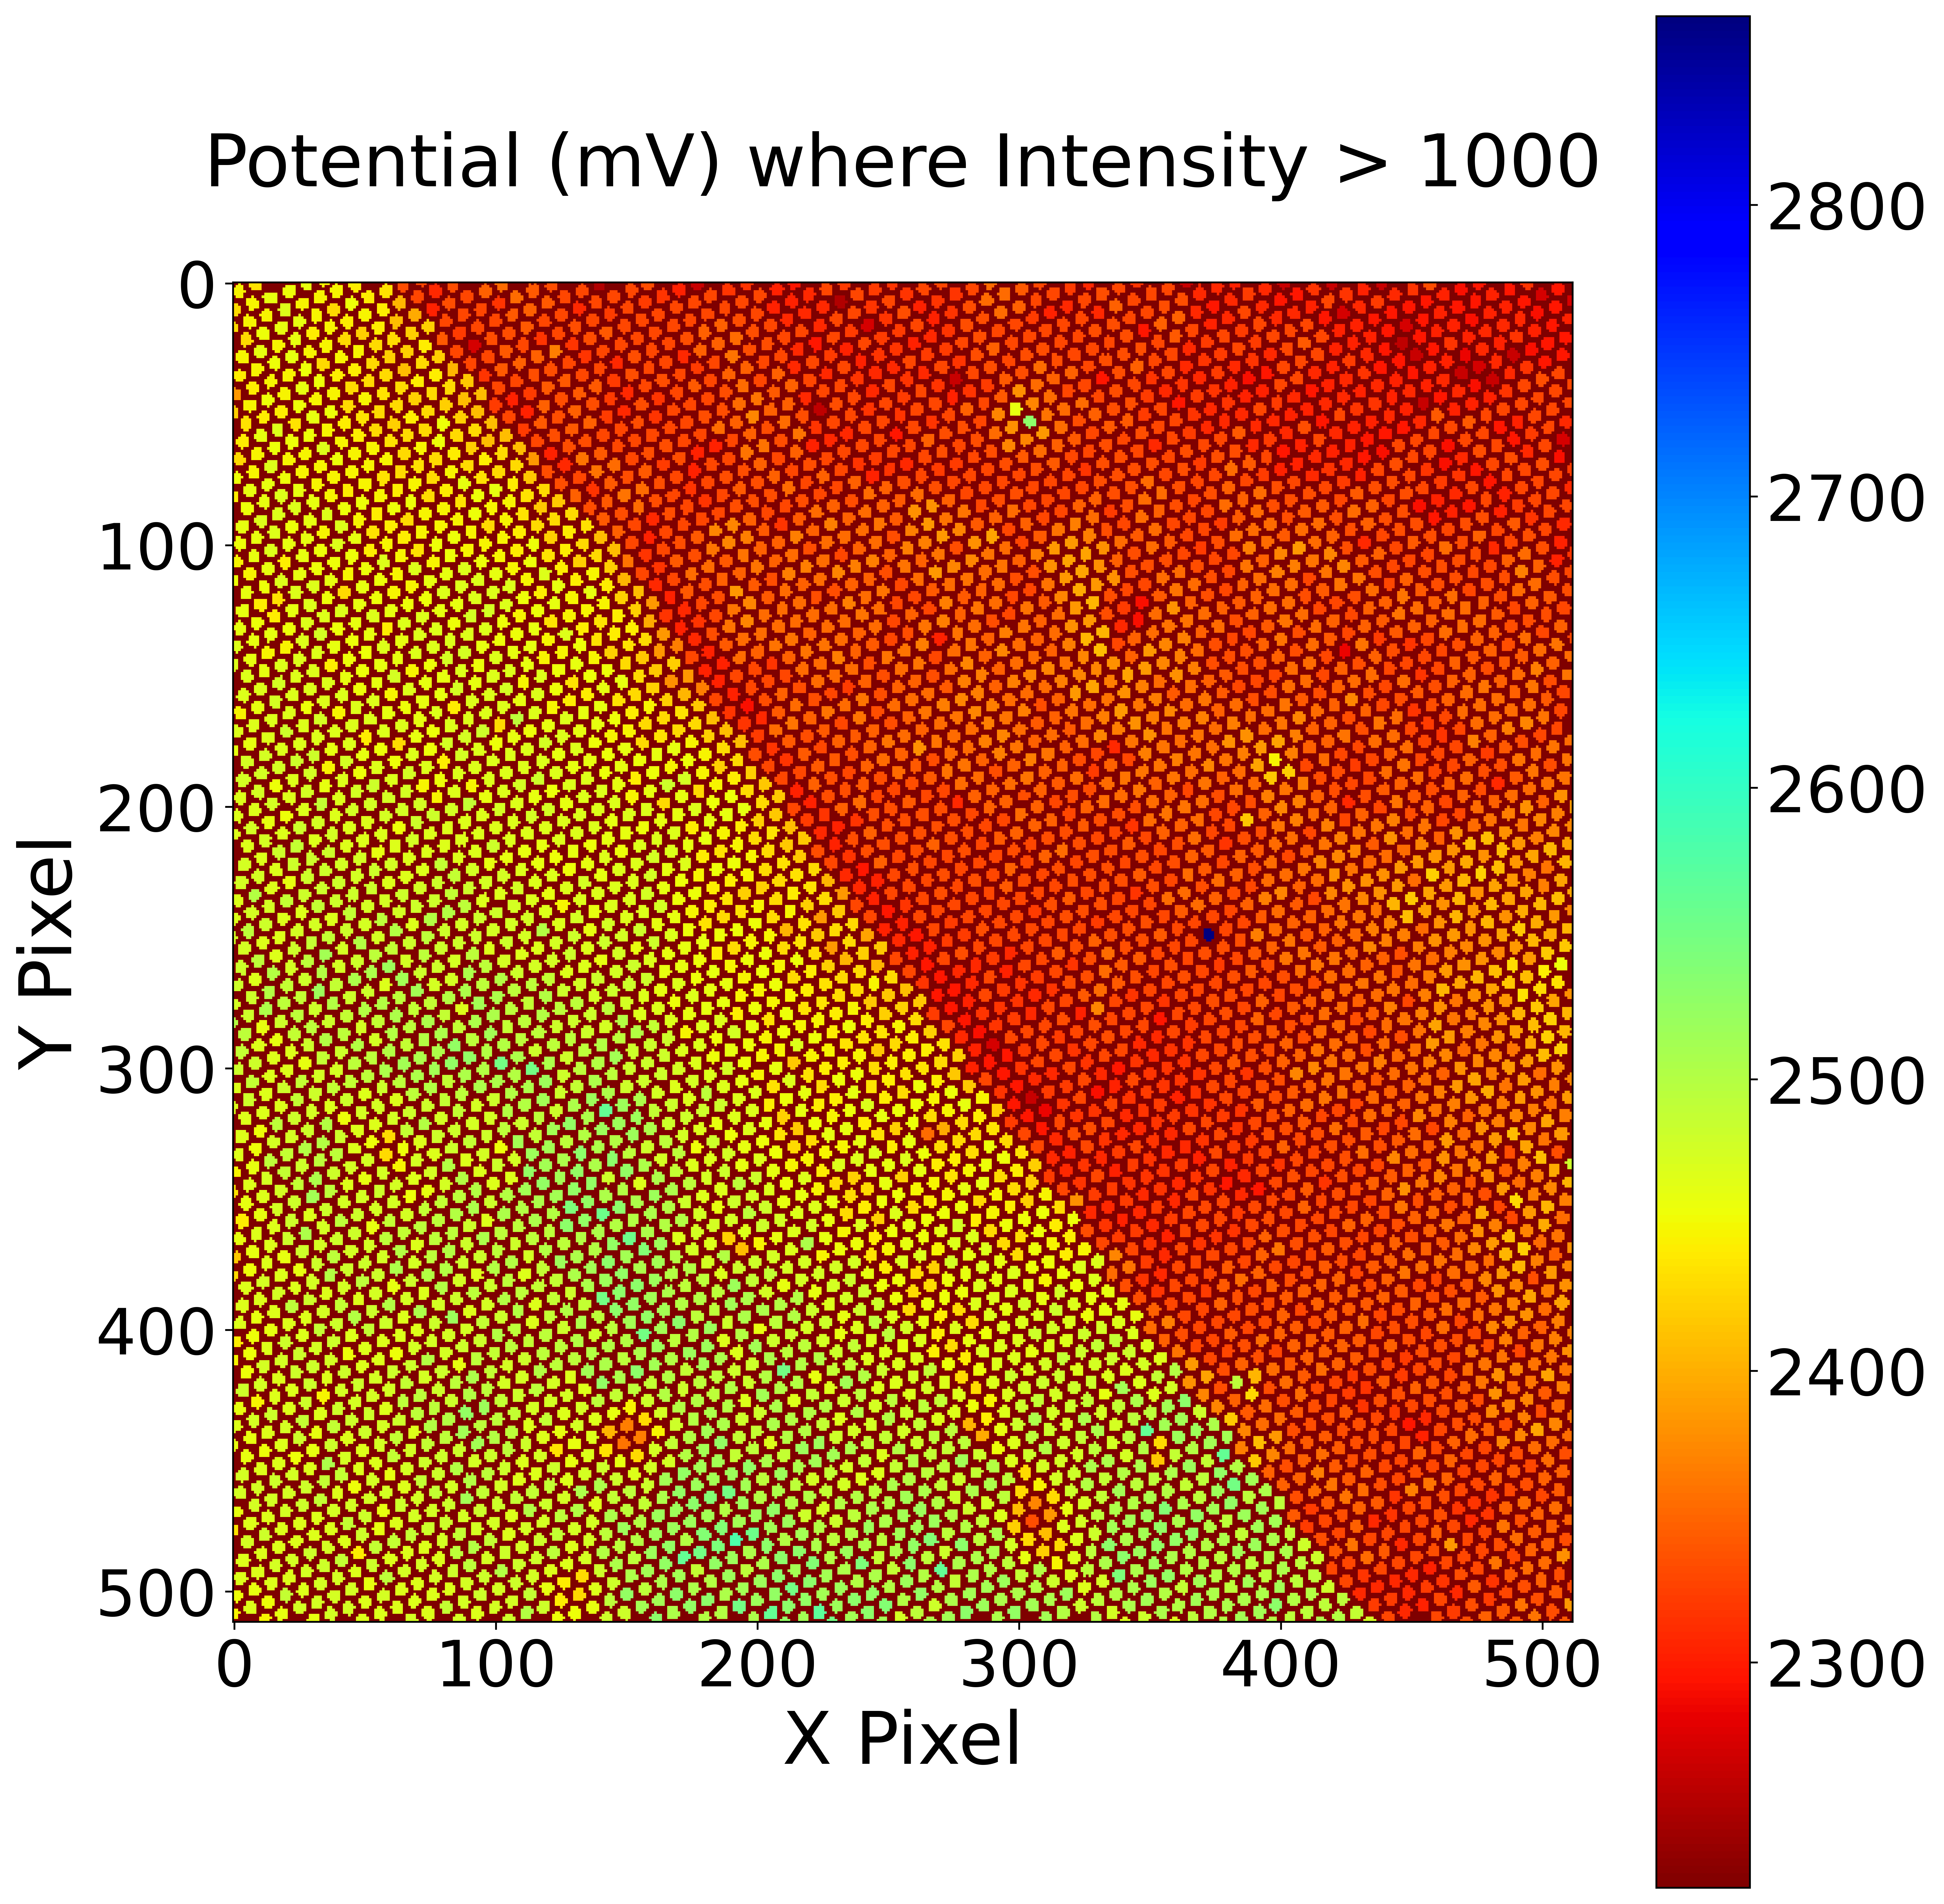

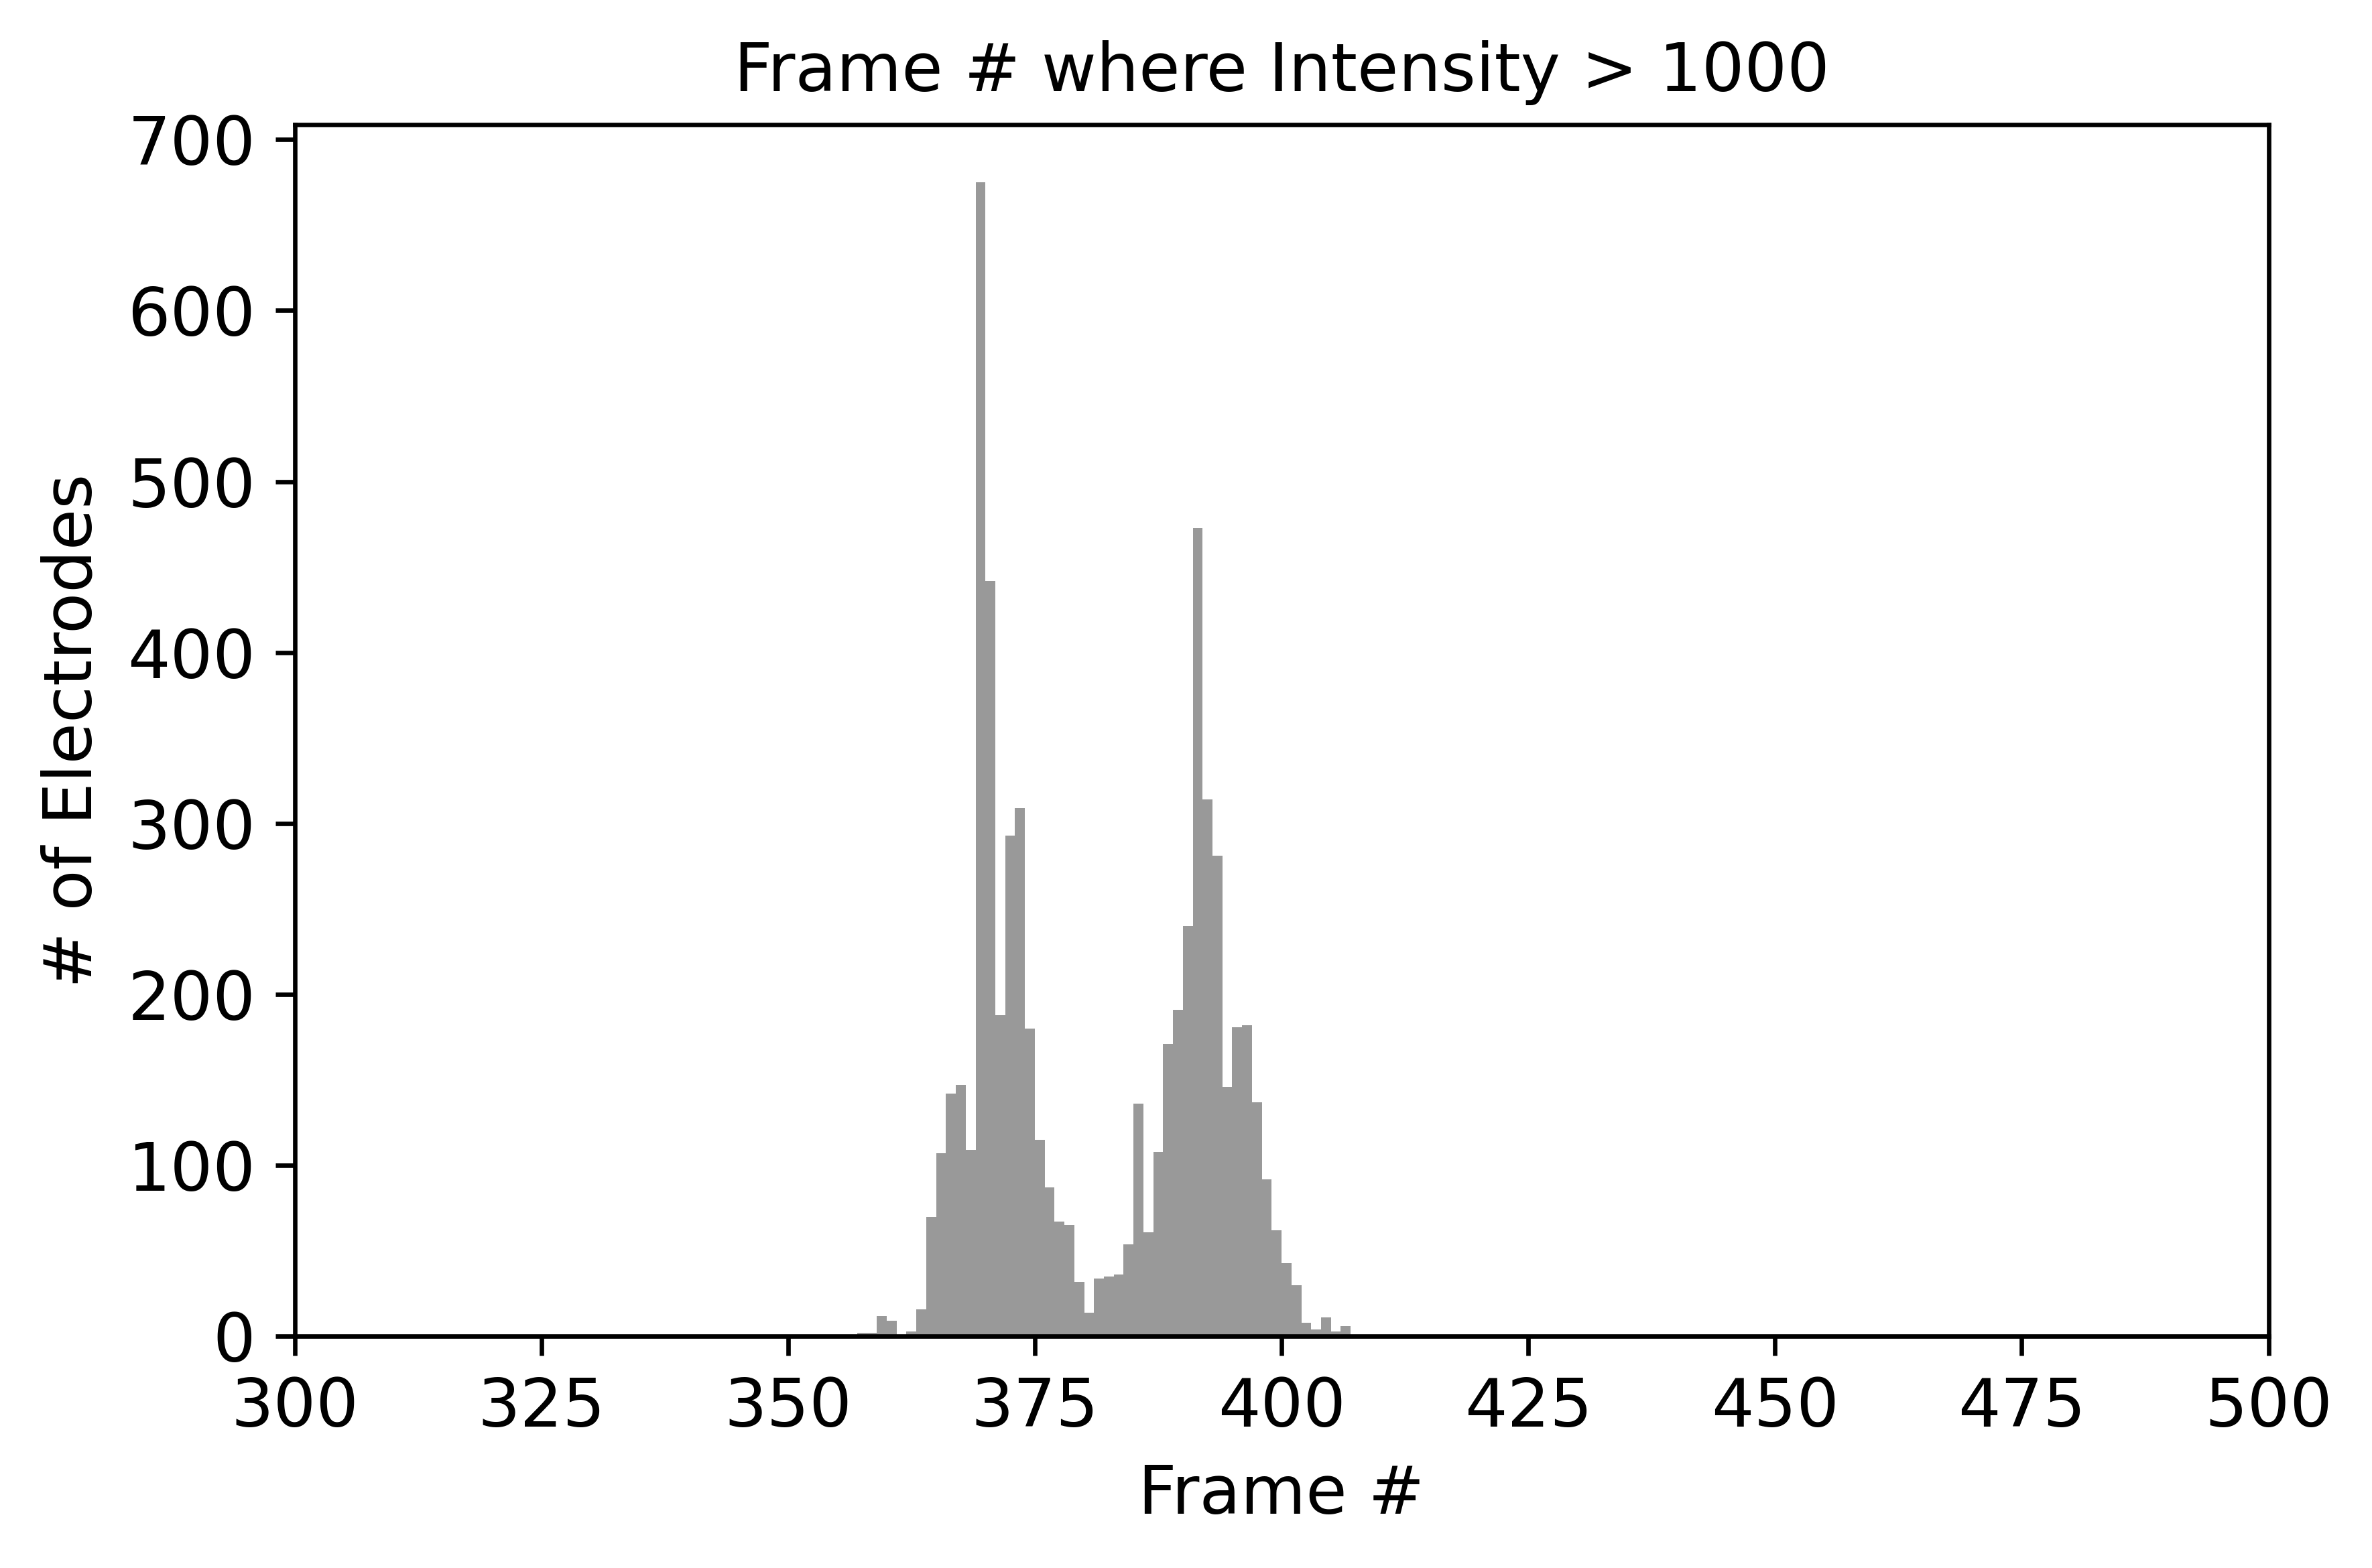

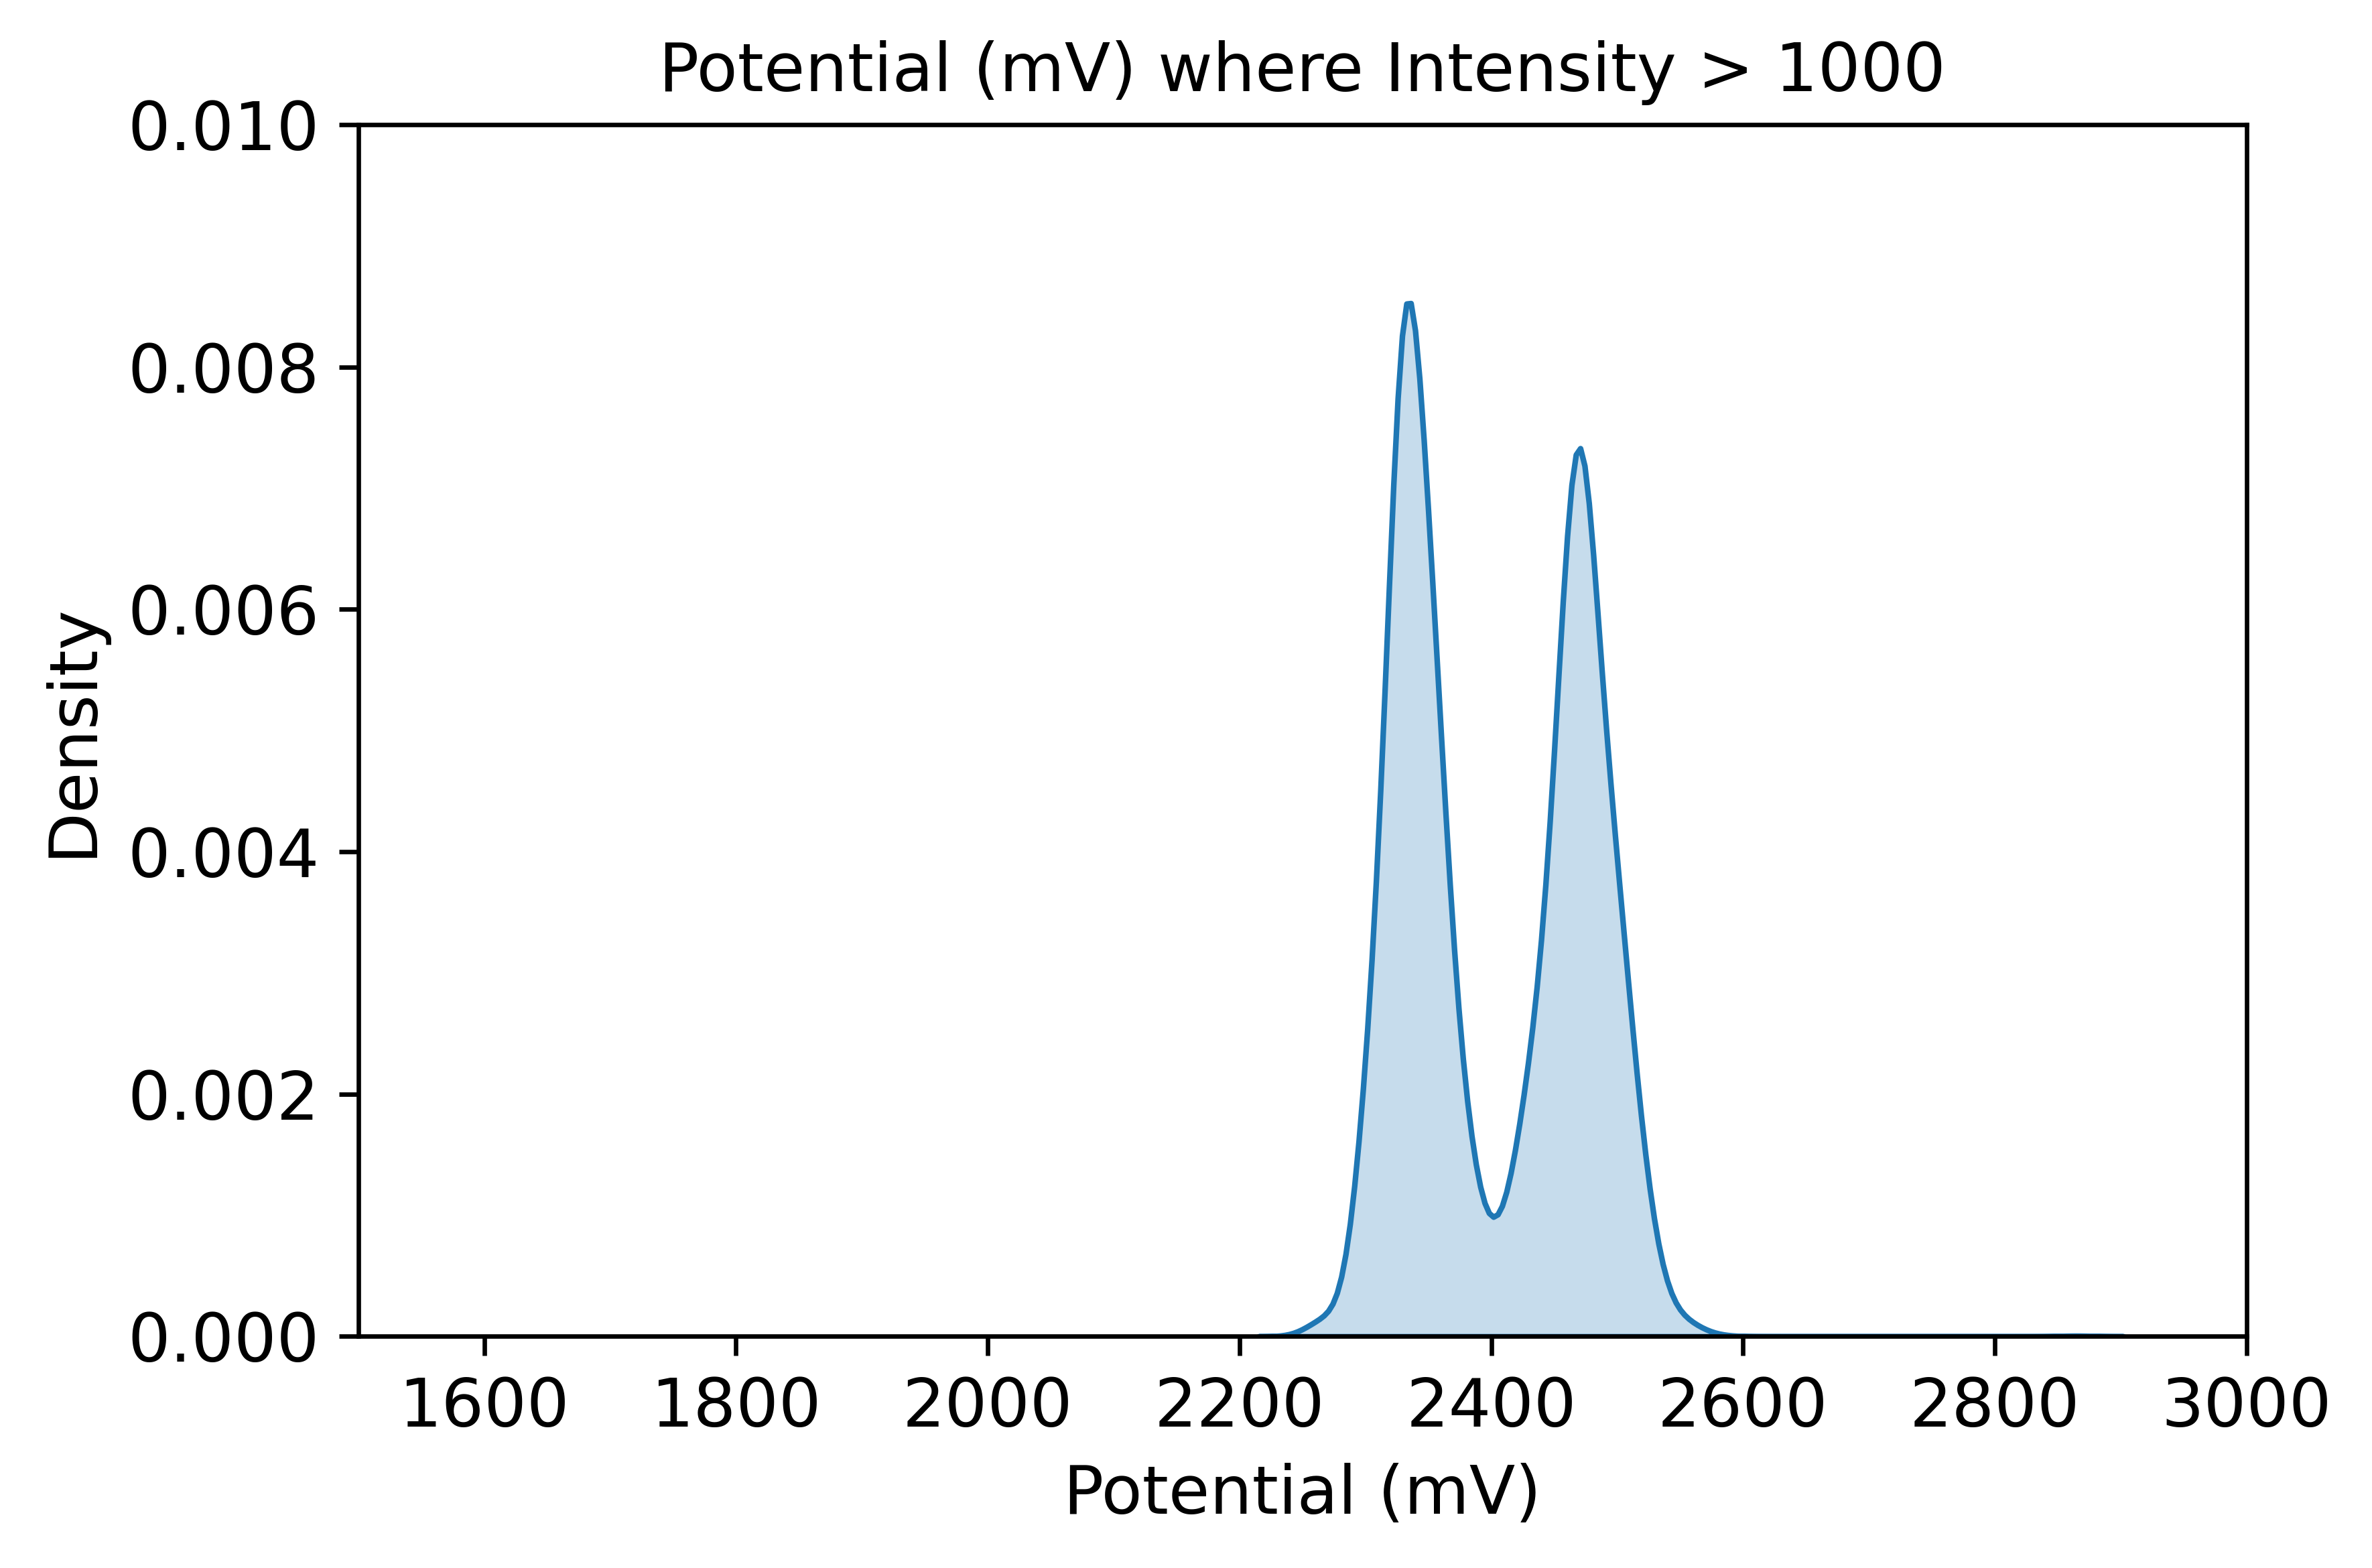

In [14]:
#Output Plots:
map_threshold(df_sort, 1000) # intensity 

**Conclusion**

The mapped output clearly shows a diagonal split between the upper and lower electrodes, distinguishing those with and without electrocatalyst present. Indeed, the histograms show two distinct populations, validating our experiment.

While this application was straightforward, the same general approach can be used to map any value of experimental importance onto the array for easier interpretation of the results!
